In [1]:
import gzip
from Bio import motifs
from Bio.motifs import jaspar
from Bio.motifs import Motif
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Bio.motifs import transfac 

In [2]:
jasparfile=open("/data/bls/wheat/jaspar/JASPAR2020_CORE_plants_non-redundant_pfms_jaspar.txt")
jasparmotifs = jaspar.read(jasparfile, "jaspar")
print(jasparmotifs[0])

TF name	ABF1
Matrix ID	MA0570.2
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11
A: 593.00  83.00 1123.00  10.00  16.00   4.00   9.00  39.00  81.00 909.00 348.00 358.00
C: 284.00 793.00   4.00 1099.00   9.00   8.00   3.00  11.00 999.00  36.00 195.00 213.00
G:  60.00 124.00  11.00  15.00 1107.00   1.00 1123.00 707.00  28.00 117.00 234.00 225.00
T: 204.00 141.00   3.00  17.00   9.00 1128.00   6.00 384.00  33.00  79.00 364.00 345.00





In [3]:
expand = {
        "A" : "A",
        "C" : "C",
        "G" : "G",
        "T" : "T",
        "N" : "ACGT",
        "R" : "AG",
        "Y" : "CT",
        "S" : "GC",
        "W" : "AT",
        "K" : "GT",
        "M" : "AC",
        "B" : "CGT",
        "D" : "AGT",
        "H" : "ACT",
        "V" : "ACG"
}
degen = "NRYSWKMBDHV"
def expandMotif(msg):
    expansions = [""]
    for c in msg:
        exp = expand[c]
        tmp = []
        for e in exp:
            for motif in expansions:
                tmp.append(motif  + e)
        expansions = tmp
    return list(map(lambda x: Seq(x), expansions))
def distribution(motiflist):
    counts = { "A" : 0, "C" : 0, "G" : 0, "T" : 0, "N" : 0, "R" : 0, "Y" : 0, "S" : 0, 
              "W" : 0, "K" : 0,  "M" : 0, "B" : 0, "D" : 0, "H" : 0, "V" : 0}
    for motif in motiflist:
        for c in motif.degenerate_consensus:
            counts[c] += 1
    return counts
def degen_distribution(motiflist, max):
    counts = {}
    for i in range(0, max + 1):
        counts[i] = 0
    for motif in motiflist:
        degencount = 0
        for c in motif.degenerate_consensus:
            if c in degen:
                degencount += 1
        counts[degencount] += 1
    return counts

In [4]:
formatprefix="AC  ID_REPLACEME\nXX\nID  ID_REPLACEME\nXX\nDE  NR_REPLACEME ; from ID_REPLACEME\n"
formatsuffix="XX\nCC  residue_type:\nCC  name: ID_REPLACEME\nXX\n//\n"
def reformat(lines, prefix, handle):
    nr = 0
    i=0
    while i < len(lines) and lines[i].startswith("P0"):
        handle.write(formatprefix.replace("ID_REPLACEME", prefix + str(nr)).replace("NR_REPLACEME", str(nr)))
        while not lines[i].startswith("XX"):
                handle.write(lines[i] + "\n")
                i += 1
        handle.write(formatsuffix.replace("ID_REPLACEME", prefix + str(nr)))
        i+=2
        nr+=1
def gt_threshold(splits, threshold, orthocount_t, blsthresholds):
    emit=False
    for i in range(0, blsthresholds):
        if int(splits[i+1]) > orthocount_t and float(splits[i+1+blsthresholds]) > threshold:
            emit=True
    return emit
def lt_threshold(splits, threshold, blsthresholds):
    max = float('-inf')
    for i in range(0, blsthresholds):
        if float(splits[i+1+blsthresholds]) > max:
            max = float(splits[i+1+blsthresholds])
    return max < threshold

In [7]:
blssplitlines=list(map(lambda line: str(line.strip()).split("\t"), gzip.open("/data/bls/wheat/output/final-bls-l8-a3-d3.motifs.gz", "rt").readlines()))

In [14]:
m=motifs.create(expandMotif(blssplitlines[0][0]))
m.pwm

{'A': (0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0),
 'C': (0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 'G': (0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0),
 'T': (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0)}

In [71]:
blssplitlines=map(lambda line: str(line.strip()).split("\t"), gzip.open("/data/bls/wheat/output/final-bls-l8-a3-d3.motifs.gz", "rt").readlines())
blsthresholds=5
orthocount_t = 100 # at least preserved in 100 ortho groups
hq_t = 0.87
hq_bls = list(map(lambda x: motifs.create(expandMotif(x[0])), filter(lambda x: gt_threshold(x, hq_t, orthocount_t, blsthresholds), blssplitlines)))

In [72]:
blssplitlines=map(lambda line: str(line.strip()).split("\t"), gzip.open("/data/bls/wheat/output/final-bls-l8-a3-d3.motifs.gz", "rt").readlines())
lq_t = 0.5
lq_bls = list(map(lambda x: motifs.create(expandMotif(x[0])), filter(lambda x: lt_threshold(x, lq_t, blsthresholds), blssplitlines)))

In [73]:
print(len(hq_bls), len(lq_bls))

2116 2137


In [131]:
f = open("/data/bls/wheat/jaspar/len8/low_c_l8.txt","w")
reformat(transfac.write(hq_bls).split("\n"), "low_c_l10", f)
f.close()
f = open("/data/bls/wheat/jaspar/len8/high_c_l8.txt","w")
reformat(transfac.write(lq_bls).split("\n"), "high_c_l10", f)
f.close()

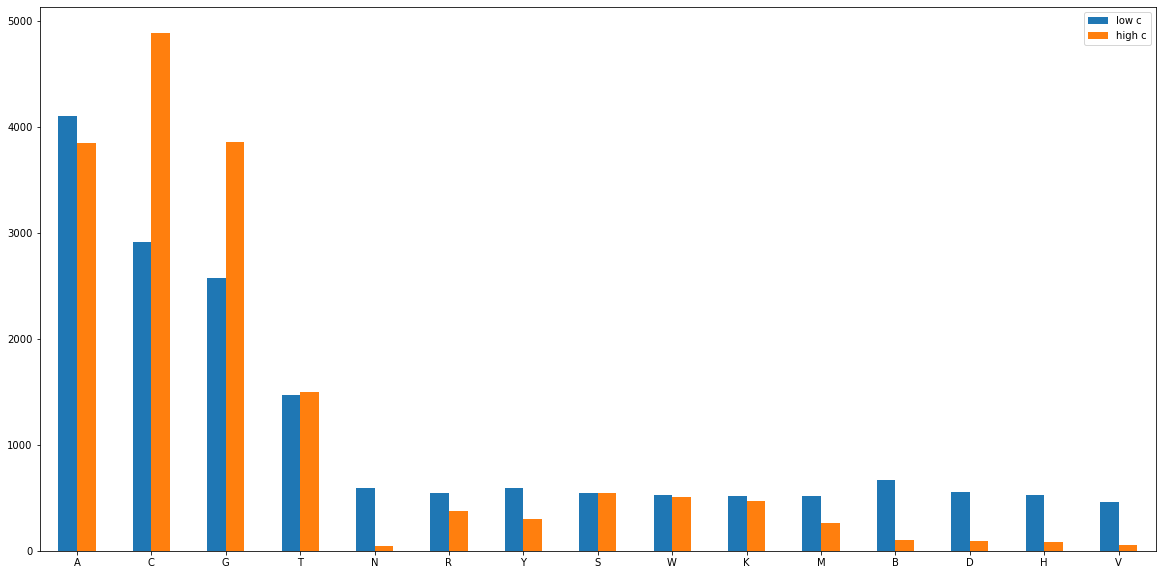

In [69]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]
lq_dist = distribution(lq_bls)
hq_dist = distribution(hq_bls)
index = ['A', 'C', 'G', 'T', 'N', 'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V']
lq_counts = []
hq_counts = []
for i in index:
    lq_counts.append(lq_dist[i])
    hq_counts.append(hq_dist[i])
df = pd.DataFrame({'low c': lq_counts, 'high c': hq_counts}, index=index)
ax = df.plot.bar(rot=0)

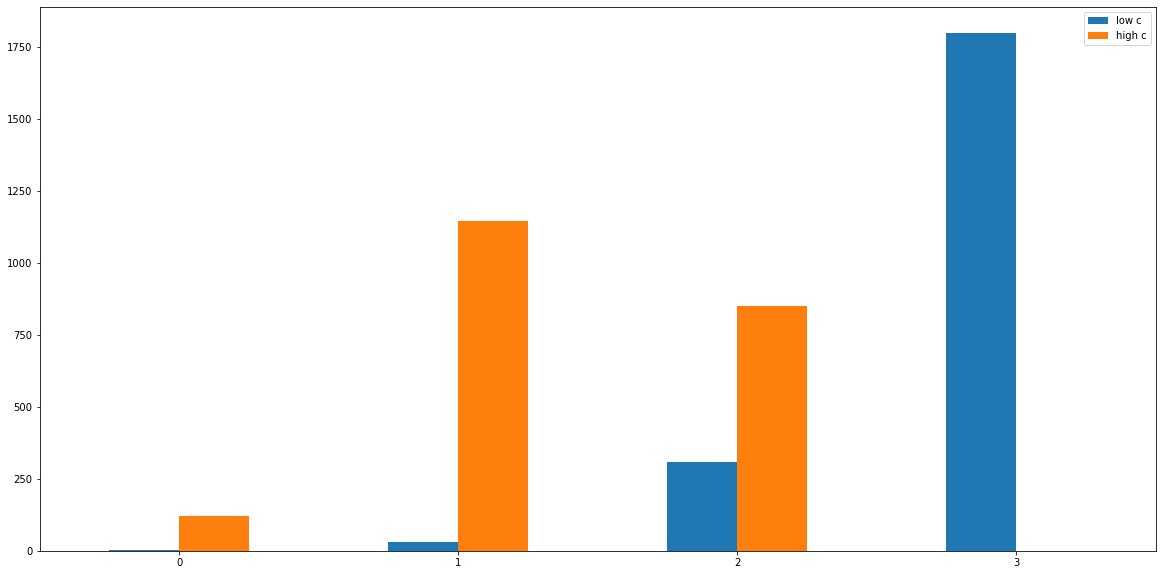

In [70]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]
lq_dist = degen_distribution(lq_bls, 3)
hq_dist = degen_distribution(hq_bls, 3)
index = [0, 1, 2, 3]
lq_counts = []
hq_counts = []
for i in index:
    lq_counts.append(lq_dist[i])
    hq_counts.append(hq_dist[i])
df = pd.DataFrame({'low c': lq_counts, 'high c': hq_counts}, index=index)
ax = df.plot.bar(rot=0)